In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from scipy.sparse.csgraph import minimum_spanning_tree, shortest_path
from scipy.interpolate import splprep, splev

# =========================
# 1. Load data
# =========================
VIT_PATH = '/home/maria/ProjectionSort/data/google_vit-base-patch16-224_embeddings_logits.pkl'
NEURAL_PATH = '/home/maria/ProjectionSort/data/hybrid_neural_responses_reduced.npy'
AREAS_PATH = '/home/maria/ProjectionSort/data/brain_area.npy'

vit = np.load(VIT_PATH, allow_pickle=True)['natural_scenes']
R = np.load(NEURAL_PATH)
areas = np.load(AREAS_PATH, allow_pickle=True)

from sklearn.decomposition import PCA

pca = PCA(n_components=1)
vit_pc1 = pca.fit_transform(vit)[:, 0]  # shape (Nstim,)
# R: neurons × stimuli
# vit_pc1: length = stimuli

# --- Normalize ViT PC1 ---
v = (vit_pc1 - vit_pc1.mean()) / vit_pc1.std()

# --- Correlation with ViT PC1 for each neuron ---
R_centered = R - R.mean(axis=1, keepdims=True)
R_std = R.std(axis=1, keepdims=True) + 1e-8

corr = (R_centered @ v) / (R_std[:, 0] * (len(v) - 1))

# --- Sort neurons by correlation (descending) ---
order_neurons = np.argsort(-corr)  
R_sorted_neurons = R[order_neurons]

areas_sorted = areas[order_neurons]
corr_sorted = corr[order_neurons]

# --- Sort stimuli by ViT PC1 (ascending semantic axis) ---
order_stimuli = np.argsort(v)  

# Apply column reordering
R_sorted_both = R_sorted_neurons[:, order_stimuli]

# For completeness:
vit_pc1_sorted = vit_pc1[order_stimuli]
v_sorted = v[order_stimuli]

(39209, 50)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 39209 samples in 0.002s...
[t-SNE] Computed neighbors for 39209 samples in 1.440s...
[t-SNE] Computed conditional probabilities for sample 1000 / 39209
[t-SNE] Computed conditional probabilities for sample 2000 / 39209
[t-SNE] Computed conditional probabilities for sample 3000 / 39209
[t-SNE] Computed conditional probabilities for sample 4000 / 39209
[t-SNE] Computed conditional probabilities for sample 5000 / 39209
[t-SNE] Computed conditional probabilities for sample 6000 / 39209
[t-SNE] Computed conditional probabilities for sample 7000 / 39209
[t-SNE] Computed conditional probabilities for sample 8000 / 39209
[t-SNE] Computed conditional probabilities for sample 9000 / 39209
[t-SNE] Computed conditional probabilities for sample 10000 / 39209
[t-SNE] Computed conditional probabilities for sample 11000 / 39209
[t-SNE] Computed conditional probabilities for sample 12000 / 39209
[t-SNE] Computed conditional probabil

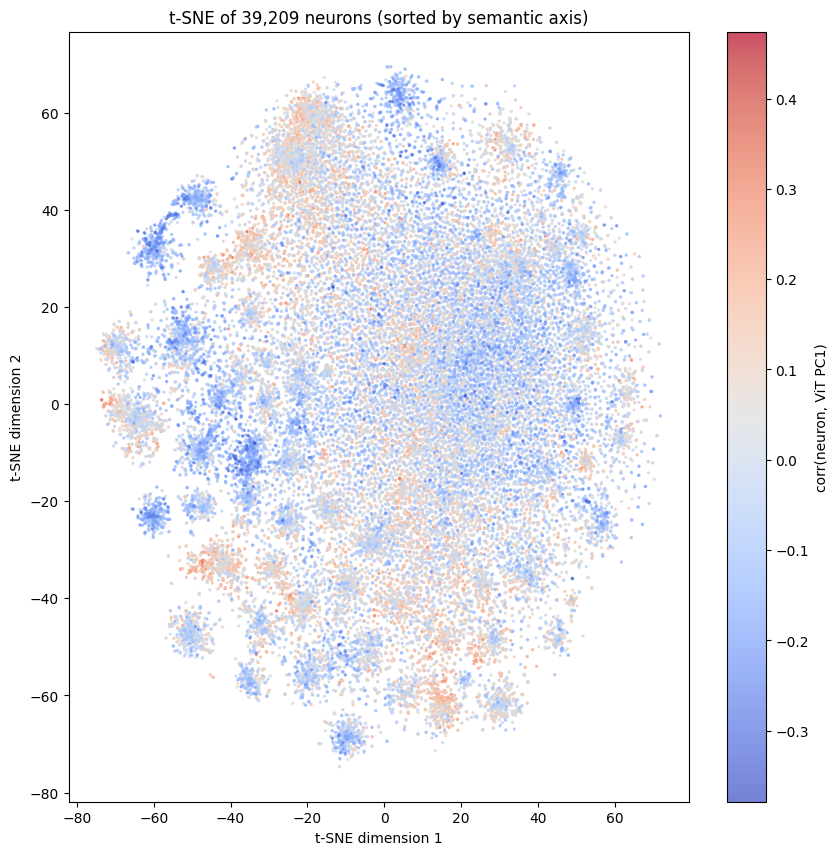

In [3]:
import numpy as np

# Z-score each neuron across stimuli
R_tsne = (R_sorted_both - R_sorted_both.mean(axis=1, keepdims=True)) / \
         (R_sorted_both.std(axis=1, keepdims=True) + 1e-8)

from sklearn.decomposition import PCA

pca = PCA(n_components=50)
X_pca = pca.fit_transform(R_tsne)
print(X_pca.shape)

from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    perplexity=40,
    learning_rate='auto',
    init='pca',
    verbose=1
)

X_tsne = tsne.fit_transform(X_pca)

import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
sc = plt.scatter(
    X_tsne[:,0], 
    X_tsne[:,1], 
    c=corr_sorted,     # semantic tuning strength
    cmap='coolwarm',
    s=2,
    alpha=0.7
)
plt.colorbar(sc, label='corr(neuron, ViT PC1)')
plt.title("t-SNE of 39,209 neurons (sorted by semantic axis)")
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.show()

